In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, fbeta_score
# from sklearn.naive_bayes import BernoulliNB
from tabulate import tabulate
import os

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import shutil
# from joblib import dump, load
import pickle
import jsonpickle
from datetime import datetime
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

%matplotlib inline 
%run ./vectorizer.ipynb

In [2]:
%run ./_preprocess.ipynb

# ds_root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/'
# r_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_random_sample_predicted.csv')
# r_df = read_file(r_path)

# m_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_v1_g.csv')
# m_df = read_file(m_path)

# raw_df = pd.concat([r_df, m_df])
raw_df = pd.read_json('./dataset/data.json', lines=True)
raw_df.reset_index(drop=True, inplace=True)
options = {
    'handle_unicode': True,
    'handle_emoji': True,
    'handle_email': True,
    'handle_username': True,
    'handle_hashtags': True,
    'handle_url': True,
    'handle_markup': True,
    'handle_retweet': True,
    'handle_case': True,
    'handle_lemmatization': True,
    'handle_stopwords': True,
    'handle_punctuation': True,
    'handle_contractions': True,
    'print_stats': True,
    'handle_spelling': False
}
df = process_data(raw_df, **options)

# replace placeholders.
df.text = df.text.str.replace('HASHTAG', '', )
df.text = df.text.str.replace('HANDLE', '')
df.text = df.text.str.replace('URL', '')
df.text = df.text.str.replace('rt', '')
df = df.reset_index(drop=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gaurav.gupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


------------------  -----------  ------------
Step                Total words  Unique words
Start               77684        20305
Remove Retweet      66365        18473
Lower               66365        16581
Remove Retweet      66649        16532
Lemmatize           66649        15779
Unicode Fix         66656        15752
Replace emoji       67043        15848
Stop words          50235        15273
Email Replace       50235        15266
UserName replace    50921        14248
HashTags Replace    64615        10461
URL Replace         64615        8398
MARKUP Replace      64615        8397
Spell Correct       xxxxxx       xxxxxx
Remove punctuation  64615        6668
------------------  -----------  ------------


In [10]:

def test_model(model, x_test, y_test, print_stats = False):
    pred_test = model.predict(x_test)
    model_acc_score = accuracy_score(y_test, pred_test)
    model_f1_score = f1_score(y_test, pred_test)
    model_prec_score = precision_score(y_test, pred_test)
    model_recall_score = recall_score(y_test, pred_test)
    model_f2_score = fbeta_score(y_test, pred_test, beta=2)
    results = [('Accuracy', 'Precision', 'Recall', 'F1', 'F2')]
    scores = [model_acc_score, model_prec_score, model_recall_score, model_f1_score, model_f2_score]
    results.append((scores))
    if print_stats:
        print(tabulate(results, tablefmt='simple'))
    return pred_test, scores


def plot_important_features(clf, tfidf, axs):
    # Display Important feature
    n = 30
    f_imp = [list(i) for i in list(
        zip(clf.feature_importances_, tfidf.get_feature_names()))]
    f_imp_df = pd.DataFrame(f_imp, columns=['Importance', 'Feature'])
    top_n_features = f_imp_df.sort_values(
        by=['Importance'], ascending=False).head(n).sort_values(by=['Importance'])
    axs[1].barh(top_n_features['Feature'], top_n_features['Importance'])
    axs[1].set_title('MOST Important feature as per RF')
    return


TrainSet: (1694, 188)	HoldOut Set:(727, 188)
Training and testing on cross validation set.
+Train: 281	-Train: 1243	+CV: 33	-CV: 137
+Train: 280	-Train: 1244	+CV: 34	-CV: 136
+Train: 279	-Train: 1245	+CV: 35	-CV: 135
+Train: 274	-Train: 1250	+CV: 40	-CV: 130
+Train: 283	-Train: 1242	+CV: 31	-CV: 138
+Train: 288	-Train: 1237	+CV: 26	-CV: 143
+Train: 294	-Train: 1231	+CV: 20	-CV: 149
+Train: 291	-Train: 1234	+CV: 23	-CV: 146
+Train: 279	-Train: 1246	+CV: 35	-CV: 134
+Train: 277	-Train: 1248	+CV: 37	-CV: 132
------------------  ------------------  ------------------  ------------------  ------------------
Accuracy            Precision           Recall              F1                  F2
0.9411764705882353  0.8285714285714286  0.8787878787878788  0.8529411764705883  0.8682634730538924
0.9058823529411765  0.78125             0.7352941176470589  0.7575757575757576  0.7440476190476191
0.9470588235294117  0.8611111111111112  0.8857142857142857  0.8732394366197184  0.880681818181818
0.941176470

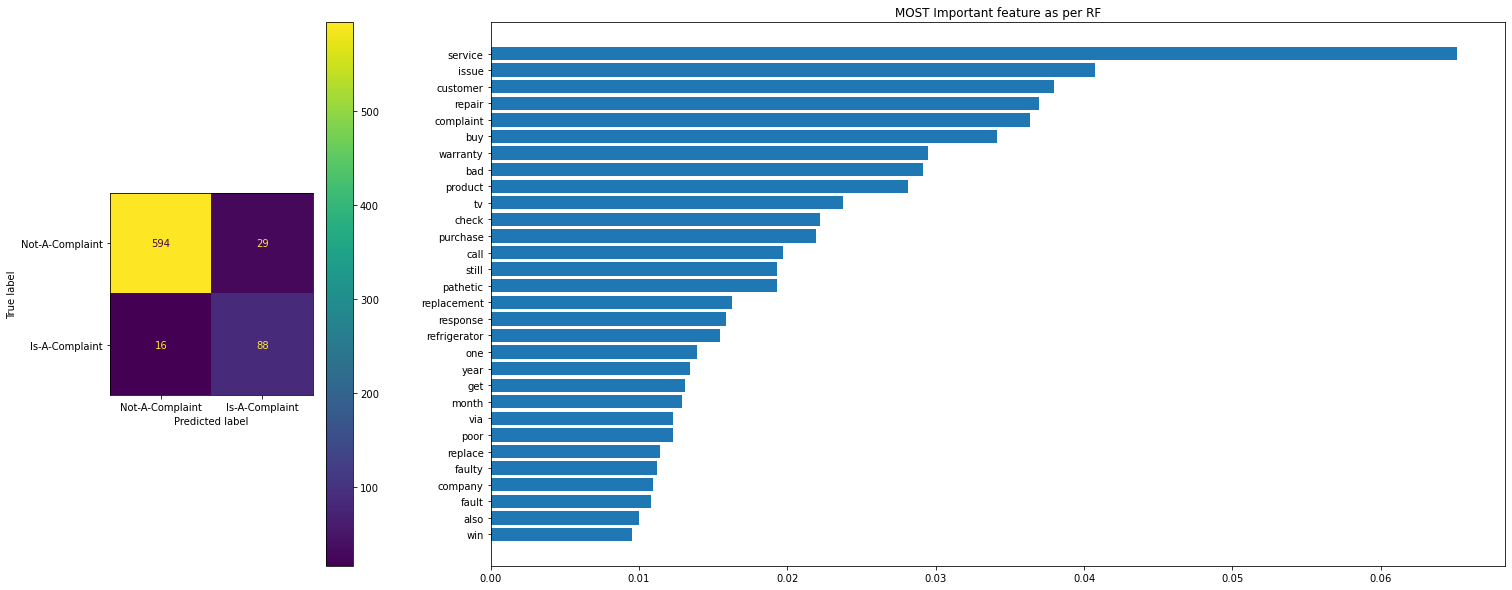

In [11]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
# scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error')
labelEncoder = OrderedDict({ 'Not-A-Complaint': 0, 'Is-A-Complaint': 1, })
display_labels = list(labelEncoder.keys())
labels = list(labelEncoder.values())

# max_df: Ignore terms that occur in MORE THAN N% of document.  CORPUS-SPECIFIC-STOPWORDS.
# min_df: Ignore terms that occur in LESS THAN N% of document.
# model_d2v = train_doc_model(df.text, vector_size=128)
# vectors = create_documents_vectors_from_Doc2Vec(df.text, model_d2v, vector_size=128)

# df = df.reset_index()
tfidf = TfidfVectorizer(lowercase=False, max_df=0.8, min_df=0.01, ngram_range=(1,1))  # Most of the terms are eliminated by min_df 
vectors = tfidf.fit_transform(df['text']).toarray()  # 2
x_train, x_test, y_train, y_test = train_test_split(vectors, df['Complaint'], random_state=42, test_size=0.30)  # 1
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# clf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=210, max_features=11, criterion='gini', oob_score=True, class_weight='balanced')
clf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=174, max_features=4, criterion='gini', oob_score=True, class_weight='balanced')

print(f'TrainSet: {x_train.shape}\tHoldOut Set:{x_test.shape}')
def train_and_validate_model(x_train, y_train):
    k_fold_scores = [['Accuracy', 'Precision', 'Recall', 'F1', 'F2']]
    for train_index, test_index in kf.split(x_train, y_train):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train.to_numpy()[train_index]

        x_test_fold = x_train[test_index]
        y_test_fold = y_train.to_numpy()[test_index]

        train_1, train_0 = y_train_fold[y_train_fold == 1].shape[0], y_train_fold[y_train_fold == 0].shape[0]
        Cv_1, Cv_0 = y_test_fold[y_test_fold == 1].shape[0], y_test_fold[y_test_fold == 0].shape[0]
        print(f'+Train: {train_1}\t-Train: {train_0}\t+CV: {Cv_1}\t-CV: {Cv_0}')

        clf.fit(x_train_fold, y_train_fold)
        _, score = test_model(clf, x_test=x_test_fold, y_test=y_test_fold)
        k_fold_scores.append(score)
    return clf, k_fold_scores


print('Training and testing on cross validation set.')
clf, k_fold_scores = train_and_validate_model(x_train, y_train)
print(tabulate(k_fold_scores))
print('xxxxxxxxxx Training complete xxxxxxxxxxxxxx')

print('Validate model on test set.')
pred_test, test_score = test_model(clf, x_test=x_test, y_test=y_test, print_stats=True)
fig, axs = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 4]})
plot_confusion_matrix(clf, x_test, y_test, labels=labels, display_labels=display_labels, ax=axs[0])
plot_important_features(clf, tfidf, axs)
plt.show()


In [11]:
root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_ml'

def get_model_info(model, model_name):
    info = {
        'name': str(model.__class__),
        model_name: model.get_params()
    }
    return info

def get_experiment_info(model_dict, tags):
    experiment_info = {
        'models_info': [get_model_info(model_dict[m], m) for m in model_dict.keys()],
        'tags': tags,
        'timestamp': datetime.now().isoformat()}
    return experiment_info

def save_experiment(experiment_name, model_dict, tags, results={}, preprocess_details={}):
    folder = os.path.join(root, 'experiments', experiment_name)
    # models = list(model_dict.values())
    model_names = model_dict.keys()
    readme_file_path = os.path.join(folder, 'artifacts.json')
    results_fp = os.path.join(folder, 'results.csv')

    experiment_info = get_experiment_info(model_dict, tags)
    experiment_info['name'] = experiment_name
    experiment_info['results'] = results
    experiment_info['preprocess_config'] = preprocess_details

    # Write models.
    os.makedirs(folder)
    [pickle.dump(model_dict[name], open(os.path.join(folder, f'{name}.pickle'), 'wb')) for name in model_names]
    
    frozen = jsonpickle.encode(experiment_info, indent=4)
    with open(readme_file_path, "w") as outfile:
        outfile.write(frozen)
    return

def load_model(experiment_name):
    # pickle.dump(tfidf, open("./models/tfidf_rf_f1_9371.pickle", "wb"))
    # dump(clf, './models/rf_f1_9371.joblib')
    experiment_path = f"{root}/experiments/{experiment_name}"
    vectorizer = pickle.load(open(f"{experiment_path}/vectorizer.pickle", "rb"))
    clf = pickle.load(open(f"{experiment_path}/classifier.pickle", 'rb'))
    model_dict = { 'classifier': clf, 'vectorizer': vectorizer }
    return model_dict

model_dict = OrderedDict({ 'classifier': clf, 'vectorizer': tfidf })
experiment_name = "RF_FBeta_Unigram_8255_Jan18"
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
experiment_results = {
    "tn": float(tn), "fp": float(fp), "fn": float(fn), "tp": float(tp),
    "model_acc_score" : float(accuracy_score(y_test, pred_test)),
    "model_f1_score" : float(f1_score(y_test, pred_test)),
    "model_prec_score": float(precision_score(y_test, pred_test)),
    "model_recall_score": float(recall_score(y_test, pred_test)),
    "model_f2_score": float(fbeta_score(y_test, pred_test, beta=2)),
}

notes = { 'details': ['Uni Model', 'Remove Excessive Spaces', 'Handle contractions'] }

# SAVE THE EXPERIMENT ARTIFACTS
shutil.rmtree(os.path.join(root, 'experiments', experiment_name), ignore_errors=True)
save_experiment(experiment_name, model_dict, tags=notes, results=experiment_results, preprocess_details=options)


# LOAD THE EXPERIMENT ARTIFACTS
# model_dict = load_model(experiment_name)
# sample_vector = model_dict['vectorizer'].transform(['This raise complaint'])
# sample_predic = model_dict['classifier'].predict(sample_vector)
# sample_predic

In [12]:

def prediction_service(sample_text, vectorizer=tfidf, clf=clf):
   sample_df = pd.DataFrame(data={'text': sample_text})
   sample_df = process_data(sample_df, **options)
   sample_df.text = sample_df.text.str.replace('HASHTAG', '', )
   sample_df.text = sample_df.text.str.replace('HANDLE', '')
   sample_df.text = sample_df.text.str.replace('URL', '')
   sample_df.text = sample_df.text.str.replace('rt', '')
   sample_vector = vectorizer.transform(sample_df['text'])
   ans = clf.predict(sample_vector)
   probs = clf.predict_proba(sample_vector)
   prob_of_being_complaint = probs[:,1:2]
   sample_df['Prediction'] = ans
   sample_df['Predict_Probab'] = prob_of_being_complaint
   return sample_df

# sample_text = [
#             'This is such a poor product. It didnot worked for even 1 day',
#             "#panasonicindia I tweeted again and again but still my complaint is not resolve",
#             "@PanasonicIndia I've a 32 LCD/LED tv Model No. TH-W32ES48DX in which I'm having an issue to see Netflix under the Market Apps section. How do I fix this?",
#             "Disposed my laptop successfully with the help of @PanasonicIndia #DiwaliwaliSafai #PanasonicIndia Join @chidambar08 @dayalojha_ @AswaniJaishree",
#             "Panasonic's Akhil Sethi joins Harman India as digital marketing head #HarmanIndia #Panasonic #AkhilSethi #Vivo #Isobar #Devices #PanasonicIndia",
#          ]


experiment_name = 'RF_FBeta_Unigram_8255_Jan18'
model_dict = load_model(experiment_name)
vectorizer = model_dict['vectorizer']
classifier = model_dict['classifier']
df = pd.read_json('~/Desktop/PanasonicAll.json', lines=True)
data_to_predict = list(df['Orig_text'])
results = prediction_service(data_to_predict, vectorizer=vectorizer, clf=classifier)
# print(results.loc[2][0])
# results


In [25]:
remote_total = df.shape[0]
local_total = results.shape[0]

remote_num_comp = df[df['Complaint'] == 1].shape[0]
local_num_comp = results[results['Prediction'] == 1].shape[0]

print(f'REMOTE DF\tComplaints: { remote_num_comp }\tTotal: {remote_total}\tColumns: {df.columns}\t')
print(f'Local DF\tComplaints: { local_num_comp } \tTotal: {local_total}\tColumns: {results.columns}')


REMOTE DF	Complaints: 3670	Total: 184272	Columns: Index(['Orig_text', 'text', 'Complaint'], dtype='object')	
Local DF	Complaints: 1564 	Total: 106816	Columns: Index(['text', 'orig_text', 'Prediction', 'Predict_Probab'], dtype='object')


In [7]:
results.head(2)

,text,orig_text,Prediction,Predict_Probab
1,hi guy restock,Hi @shashinki when will you guys restock #Pana...,0,0.412752
3,one indias best faculty dedicate dreams join ...,We have one of India’s best faculty dedicated ...,0,0.398557


In [8]:
comp_df = pd.merge(df, results, left_on='Orig_text', right_on='orig_text', how='inner')
comp_df.head(2)

,Orig_text,text_x,Complaint,text_y,orig_text,Prediction,Predict_Probab
0,Hi @shashinki when will you guys restock #Pana...,hi HANDLE guy restock HASHTAG HASHTAG HASHTAG ...,0,hi guy restock,Hi @shashinki when will you guys restock #Pana...,0,0.412752
1,We have one of India’s best faculty dedicated ...,one indias best faculty dedicate dreams join H...,0,one indias best faculty dedicate dreams join ...,We have one of India’s best faculty dedicated ...,0,0.398557


In [12]:
import pandas as pd

Missed_Df = comp_df[(comp_df['Complaint'] == 1) & (comp_df['Prediction'] == 0)]
Missed_Df.shape
# Missed_Df.to_excel('~/Desktop/test.xlsx')


(33490, 7)